In [1]:
%matplotlib inline

# Volumetric Registration and Analysis
In this tutorial we align a CLARITY brain Control258 to the Allen Reference Atlas (ARA).  Thus the ARA is our _reference_ image, it consists of image data stored in the default "average" channel and corresponding annotations stored in a separate "annotation" channel.  We begin by importing the relevant modules

In [2]:
from ndreg import *
import matplotlib
import ndio.remote.neurodata as neurodata

Next we'll download the image data

In [3]:
refToken = "ara_ccf2"
refImg = imgDownload(refToken)

When given an image volume *imgShow* displays it as a set of evenly spaced z-slices (1st column), y-slices (2nd column) and x slices (3rd column).

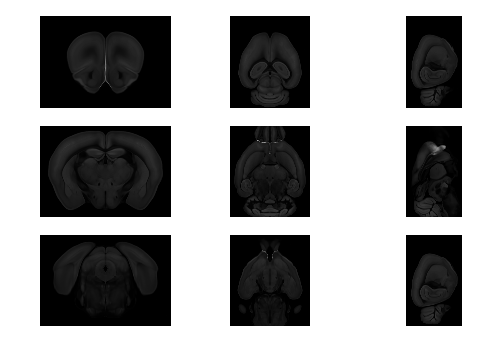

In [4]:
imgShow(refImg)

The displayed slices above are a little too dark.  So we set the visuilization max *vmax* manually.

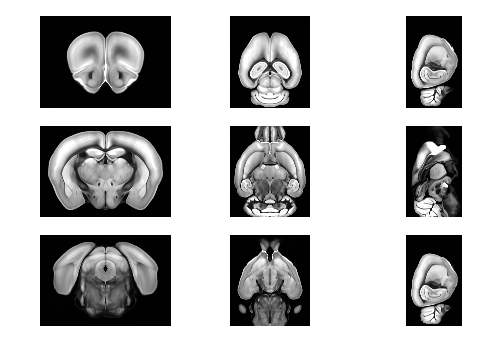

In [5]:
imgShow(refImg, vmax=500)

Now we download the atlas annotations.

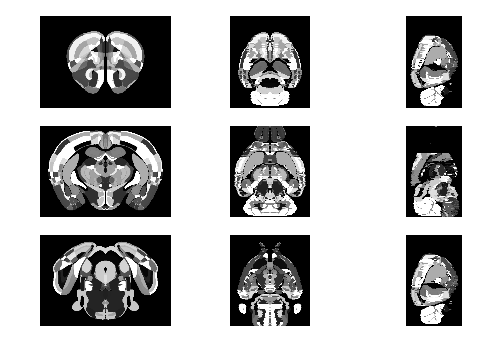

In [6]:
refAnnoImg = imgDownload(refToken, channel="annotation")
imgShow(refAnnoImg, vmax=1000)

It's usually better to visuaize a set of annotations in color.  Let's display the atlas annotations using a random colormap.  We begin by creating a 1000x3 array of random values.

In [7]:
randValues = np.random.rand(1000,3)

Since we always want the backgrond (label 0) to be black make the 0th row is [0,0,0].

In [8]:
randValues = np.concatenate(([[0,0,0]],randValues))

Now we can display the annotations.

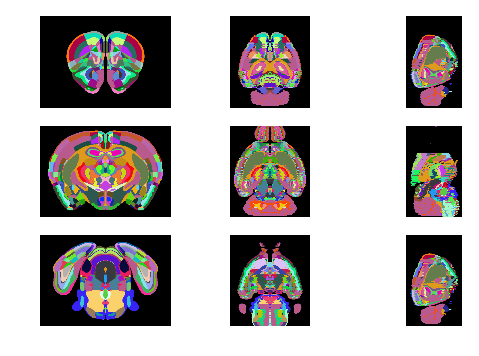

In [9]:
randCmap = matplotlib.colors.ListedColormap (randValues)
imgShow(refAnnoImg, vmax=1000, cmap=randCmap)

Let's overlay these annotations on the atlas image using alpha transparency.  To do this we must set *newFig* to *False* so that matplotlib appends the annotation data to the current figure instead of creating new one.  

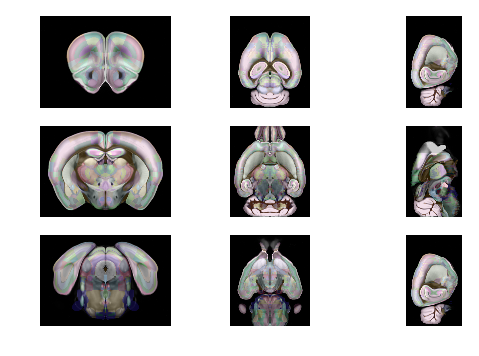

In [10]:
imgShow(refImg, vmax=500, newFig=False)
imgShow(refAnnoImg, vmax=1000, cmap=randCmap, alpha=0.2, newFig=False)
plt.show()

## Downloading CLARITY brain
Our *input* image will be CLARITY brain Control258.  At full resolution, CLARITY brains can be 1 Terabyte in size, far to large to be downloaded to a personal computer.  Thus *ndstore* stores the brains at multiple resolutions. Resolution 0 is always the highest resolution each subsequent resoltion takes up 1/4th (under slice scaling) or 1/8th (under isotropic scaling) as many bytes as the previous resoltion.  We can use ndio's get_metadata method to see a list of available resoltions.

In [11]:
inToken = "Control258"

nd = neurodata()
print(nd.get_metadata(inToken)['dataset']['voxelres'].keys())

[u'1', u'0', u'3', u'2', u'5', u'4']


Clearly resolution 5 is the lowest available resolution.  So we'll download the CLARITY image at that resolution.  Depending on your internet connection downloading may take several minutes.

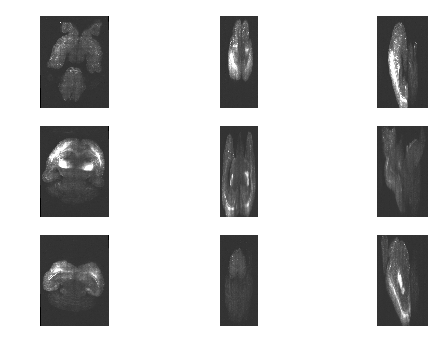

In [12]:
inImg = imgDownload(inToken, resolution=5)
imgShow(inImg, vmax=500)

In [13]:
inImg.SetSpacing([0.01872, 0.01872, 0.005]) # Setting manually due to bug https://github.com/neurodata/ndstore/issues/326

Let's make a copy of the downloaded image.  We'll need to use it later

In [14]:
inImg_download = imgCopy(inImg)

## Resampling CLARITY image
Notice how the CLARITY brain's resolution is higher than the ARA image that we want to align it to.

In [15]:
print(inImg.GetSpacing())

(0.01872, 0.01872, 0.005)


In [16]:
print(refImg.GetSpacing())

(0.024999999999999998, 0.024999999999999998, 0.024999999999999998)


Since we are aliging the CLARITY image to a lower resolution atlas, we can save memory by downsampling it to the resolution atlas.

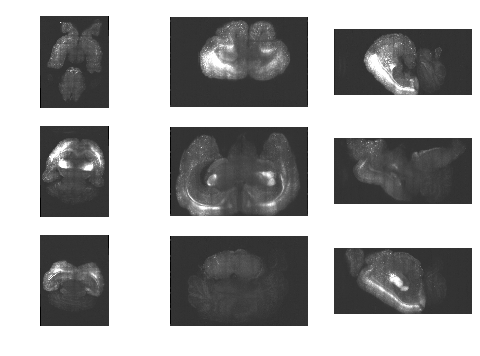

In [17]:
inImg = imgResample(inImg, spacing=refImg.GetSpacing())
imgShow(inImg, vmax=500)

## Reorienting CLARITY image
You may have noticed that the CLARITY brain is not oriented in the same way as the atlas.  Let's look at the atlas.

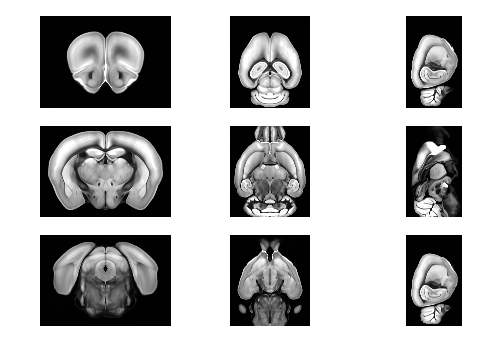

In [18]:
imgShow(refImg, vmax=500)

By examining the the z slices in the first column its clear that the x-axis goes from **R**ight to Left side of the brain. The y-axis varies from **S**uperior to Inferior and the z-axis goes from **A**nterior to posterior.  Thus it is in **RSA** orientation.  Looking at the the CLARITY brain...

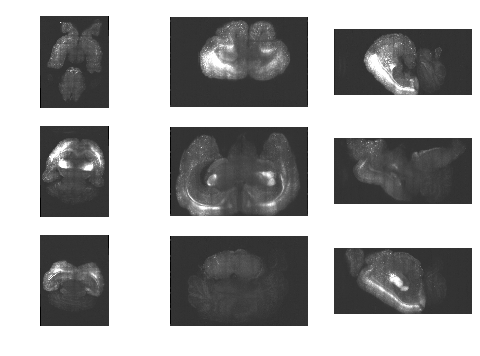

In [19]:
imgShow(inImg, vmax=500)

...we see that the x-axis goes from **L**eft to right, the y-axis goes from **A**nterior to Posterior and the Z axis goes from **I**nferior to Superior.  Thus it's in **LAI** orientation.  Therefore we reorient the CLARITY image from **LAI** to **RSA**

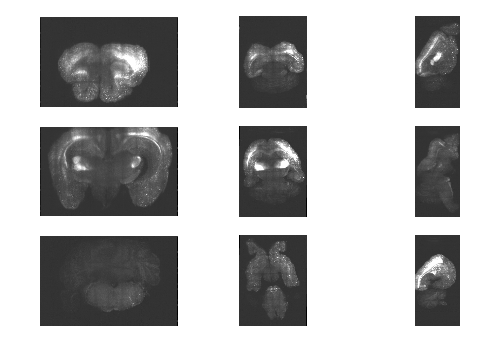

In [20]:
inImg = imgReorient(inImg, "LAI", "RSA")
imgShow(inImg, vmax=500)

Compare the above to the Atlas.  The slices should now correspond with the atlas.  Let's make a copy of this image as well because we'll need it later.

In [21]:
inImg_reorient = imgCopy(inImg)

## Thresholding CLARITY image
Lets plot the histogram of the CLARITY image

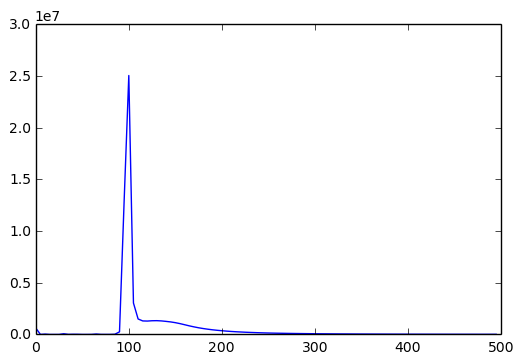

In [22]:
(values, bins) = np.histogram(sitk.GetArrayFromImage(inImg), bins=100, range=(0,500))
plt.plot(bins[:-1], values)

Notice the huge spike at 100.  This occurs because the intensity of the background is about 100. Idealy we want a black background with an intensity of 0.  Therefore we'll threhold the image below 100 and then subtract 100 from the image.

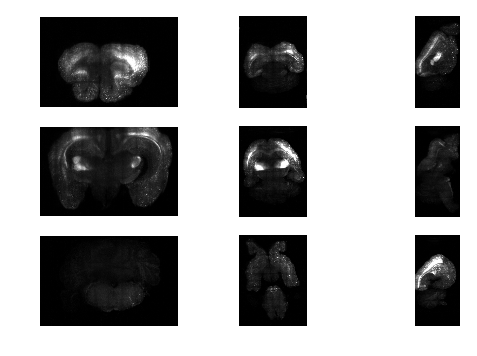

In [23]:
lowerThreshold = 100
upperThreshold = sitk.GetArrayFromImage(inImg).max()+1

inImg = sitk.Threshold(inImg,lowerThreshold,upperThreshold,lowerThreshold) - lowerThreshold
imgShow(inImg, vmax = 500)

Here's a histogram of the result

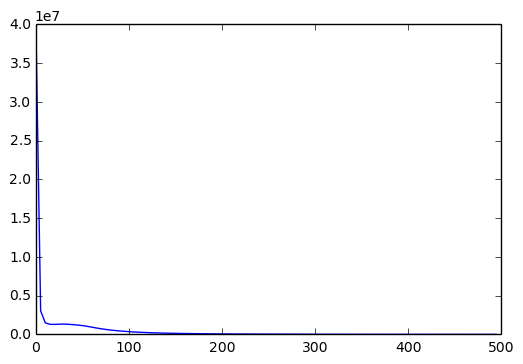

In [24]:
(values, bins) = np.histogram(sitk.GetArrayFromImage(inImg), bins=100, range=(0,500))
plt.plot(bins[:-1], values)

## Generating CLARITY mask
CLARITY brains contain really brignt fluorescent spots in the cerebral cortex and thalamus which can interfer with the registration.

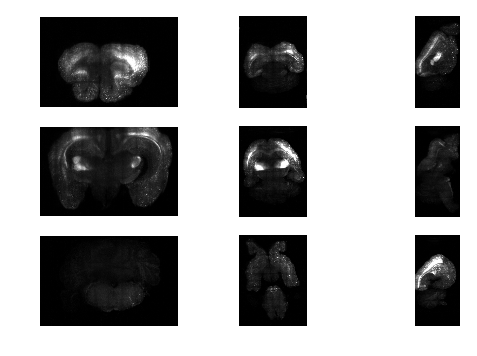

In [25]:
imgShow(inImg, vmax = 500)

To avoid this problem we create a mask which will be used to exclud the top 5% brighest voxels from registration.  To make the mask we first compute the normalized cumulative histogram.

In [26]:
(values, bins) = np.histogram(sitk.GetArrayFromImage(inImg), bins=1000)
cumValues = np.cumsum(values).astype(float)
cumValues = (cumValues - cumValues.min()) / cumValues.ptp()

We then find the first value greater than 0.95 (which is 100% - 5%)

In [27]:
maxIndex = np.argmax(cumValues>0.95)-1
threshold = bins[maxIndex]
print(threshold)

218.813


We then threshold the image using this value to obtain a mask

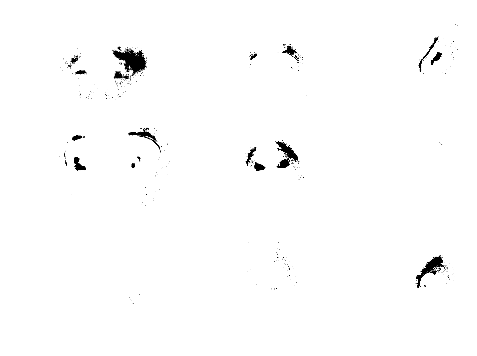

In [28]:
inMask = sitk.BinaryThreshold(inImg, 0, threshold, 1, 0)
imgShow(inMask)

The masked areas will be excluded from the registration

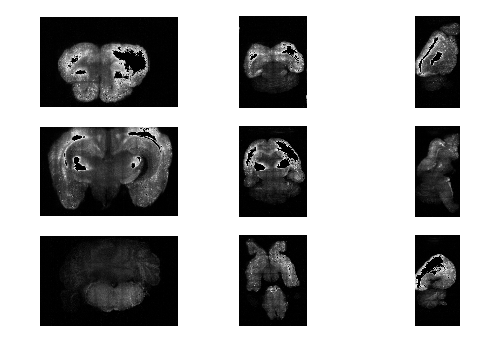

In [29]:
imgShow(imgMask(inImg,inMask))

## Affine Registration
We can finally begin the registration. Ideally we would do resgistration at the full atlas scale of 0.025 mm x 0.025 x 0.025 mm but this would be far to computationally expensive for the purposes of this tutorial.  Therefore to save time we downsample the images to 0.25 mm x 0.25mm x 0.25mm

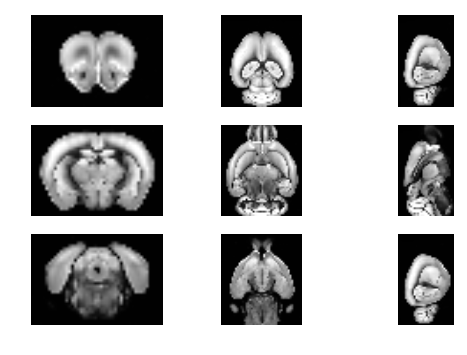

In [30]:
spacing=[0.25,0.25,0.25]
refImg_ds = imgResample(refImg, spacing=spacing)
imgShow(refImg_ds, vmax=500)

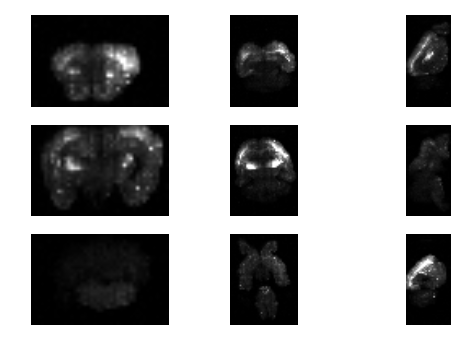

In [31]:
inImg_ds = imgResample(inImg, spacing=spacing)
imgShow(inImg_ds, vmax=500)

Notice how we used nearest-neighbor interpolation when downsampling the mask

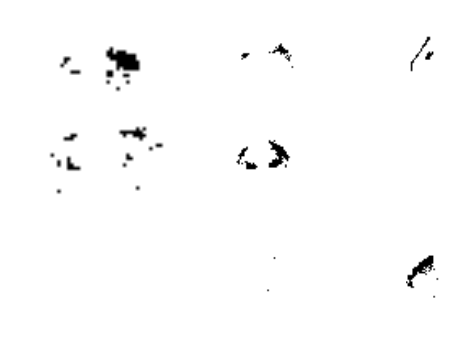

In [32]:
inMask_ds = imgResample(inMask, spacing=spacing, useNearest=True)
imgShow(inMask_ds)

Now we compute the affine transform.  Unlike in the [basic registration tutiorial](basicRegistration.ipynb) we'll use the *imgAffineComposite* instead of *imgAffine*.  *imgAffine* simply computes the affine transform between the input and reference images.  *imgAffineComposite* computes a translation then a rigid then an affine transformation.  It's output is the composition of those three transforms.  We use Mutual Information since the CLARITY and ARA images have very differnt intensity profiles.  We also enable the *verbose* option so that each iteration is printed.

In [33]:
affine = imgAffineComposite(inImg_ds, refImg_ds, inMask=inMask_ds, iterations=100, useMI=True, verbose=True)

Step translation:
0.	 -0.275686100442
1.	 -0.291574537119
2.	 -0.312210822481
3.	 -0.324350742638
4.	 -0.33517648148
5.	 -0.353540176408
6.	 -0.36026389546
7.	 -0.357676501254
8.	 -0.353962595501
9.	 -0.357357098762
10.	 -0.35456975475
11.	 -0.355968251971
12.	 -0.357432906463
13.	 -0.35622748796
14.	 -0.35740137251
15.	 -0.357406585039
Step rigid:
0.	 -0.370280002532
1.	 -0.337820206762
2.	 -0.406673900993
3.	 -0.398354914099
4.	 -0.420797981414
5.	 -0.419753067398
6.	 -0.428502075873
7.	 -0.427738664736
8.	 -0.432637993122
9.	 -0.428463468689
10.	 -0.432543825382
11.	 -0.43318037679
12.	 -0.434242966059
13.	 -0.434670876977
14.	 -0.435772840325
15.	 -0.436181934481
16.	 -0.436846803197
17.	 -0.437145371159
18.	 -0.436470989456
19.	 -0.437685185962
20.	 -0.438047773689
21.	 -0.438175621113
22.	 -0.438647549308
23.	 -0.438875294338
24.	 -0.439330892319
25.	 -0.438612923049
26.	 -0.439766455125
27.	 -0.438741003084
28.	 -0.439867826592
29.	 -0.439375528869
30.	 -0.439519139077
31.	 -0.4

Now we apply the affine transform to the input CLARITY image and mask

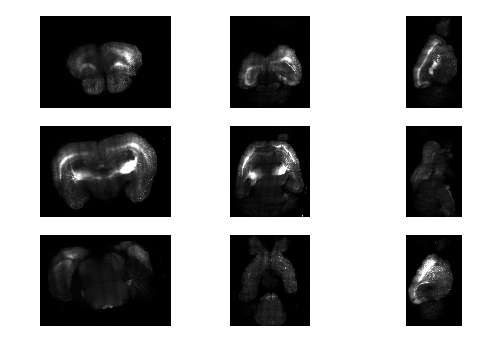

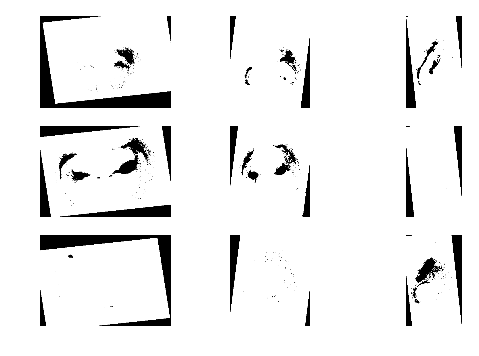

In [34]:
inImg_affine = imgApplyAffine(inImg, affine, size=refImg.GetSize())
imgShow(inImg_affine, vmax=500)

inMask_affine = imgApplyAffine(inMask, affine, size=refImg.GetSize(), useNearest=True)
imgShow(inMask_affine)

## LDDMM registration
Now we run LDDMM registration. Here we use *imgMetamorphosisComposite*.  Unlike *imgMetamorphosis* introduced in the [basic registration notebook](basicRegistration.ipynb), this function runs LDDMM in multiple steps using the alpha values specified by in *alphaList*. The *field* and *invField* outputs are the composition of all steps.  Once agan we use a Mutual Information cost because the input CLARITY brain and reference ARA average have very differnt intensity profiles.


Step 0: alpha=0.05, beta=0.05, scale=1.0
	E, E_velocity, E_rate, E_image (E_image %), LearningRate
0.	-1.86127e+10, 127.314, 0, -1.86127e+10 (97.4754%), 1.100000e-03
1.	-2.01569e+10, 259.525, 0, -2.01569e+10 (95.7687%), 1.210000e-03
2.	-2.15031e+10, 495.077, 0, -2.15031e+10 (94.2808%), 1.331000e-03
3.	-2.19493e+10, 835.298, 0, -2.19493e+10 (93.7876%), 1.464100e-03
4.	-2.27401e+10, 990.33, 0, -2.27401e+10 (92.9137%), 8.052550e-04
5.	-2.29589e+10, 1119.5, 0, -2.29589e+10 (92.6718%), 8.857805e-04
6.	-2.30649e+10, 1344.12, 0, -2.30649e+10 (92.5547%), 9.743586e-04
7.	-2.44395e+10, 1375.97, 0, -2.44395e+10 (91.0354%), 5.358972e-04
8.	-2.46966e+10, 1474.57, 0, -2.46966e+10 (90.7512%), 5.894869e-04
9.	-2.48382e+10, 1569.83, 0, -2.48382e+10 (90.5948%), 6.484356e-04
10.	-2.49504e+10, 1701.57, 0, -2.49504e+10 (90.4708%), 7.132792e-04
11.	-2.4999e+10, 1752.41, 0, -2.4999e+10 (90.4171%), 3.923035e-04
12.	-2.52125e+10, 1822.78, 0, -2.52125e+10 (90.1811%), 4.315339e-04
13.	-2.52155e+10, 1831.58, 0, 

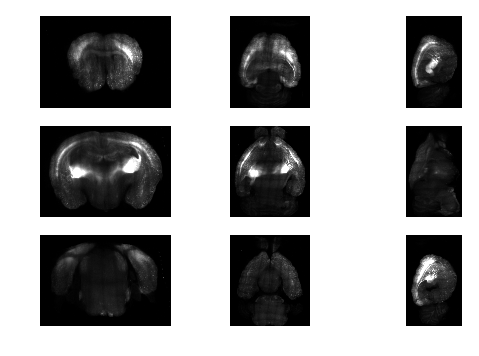

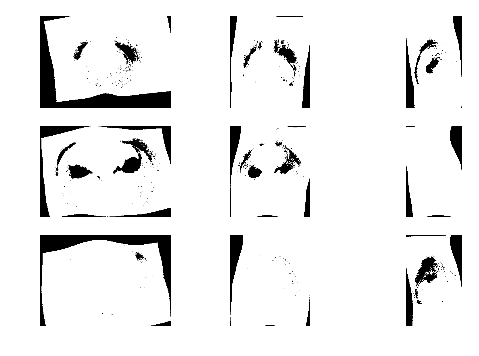

In [35]:
inImg_ds = imgResample(inImg_affine, spacing=spacing)
inMask_ds = imgResample(inMask_affine, spacing=spacing, useNearest=True)
(field, invField) = imgMetamorphosisComposite(inImg_ds, refImg_ds, inMask=inMask_ds, alphaList=[0.05, 0.02, 0.01], useMI=True, iterations=100, verbose=True)
inImg_lddmm = imgApplyField(inImg_affine, field, size=refImg.GetSize())
inMask_lddmm = imgApplyField(inMask_affine, field, size=refImg.GetSize(), useNearest=True)
imgShow(inImg_lddmm, vmax = 500)
imgShow(inMask_lddmm)

We can now overlay tha ARA annotaions on the CLARITY image.

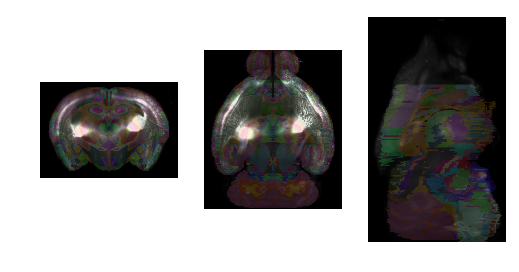

In [36]:
imgShow(inImg_lddmm, vmax=500, newFig=False, numSlices=1)
imgShow(refAnnoImg, vmax=1000, cmap=randCmap, alpha=0.2, newFig=False, numSlices=1)

## Evaluating the registration
### Evaluation using checker board
We can evaluate the registration by generating a checkerboard of the deformed CLARITY and ARA.  In this method the input image is placed on the black squares of the metaphorical checkerboard while the reference image is placed on the red squares.  Idealy anatomical sturctures should line up across squares.

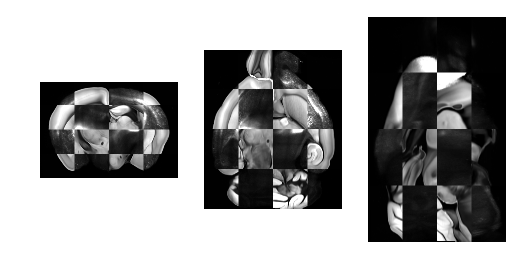

In [37]:
imgShow(imgChecker(inImg_lddmm, refImg, useHM=False), vmax=500, numSlices=1)

### Evaluation using cost functions
Another way we can evaluate the deformable alignment is by using the Mutual Information (MI) and Mean Square Error (MSE) cost functions.  Before LDDMM the MSE and MI were

In [38]:
miAffine = imgMI(inImg_affine, refImg)
print(miAffine)
mseAffine = imgMSE(inImg_affine, refImg)
print(mseAffine)

0.0860009276404
30921.7806996


After LDDMM these cost functions were 

In [39]:
miLddmm = imgMI(inImg_lddmm, refImg)
print(miLddmm)
mseLddmm = imgMSE(inImg_lddmm, refImg)
print(mseLddmm)

0.183417771508
27351.7974001


Notice how the MI has increased and the MSE has decreased indicating that LDDMM improved the alignment.  We can normalize these values to a range of [0,1] where a value of 1 represents the worst possible value (no alignment) and 0 represents the best possible value (deformed input and reference images are identical)

In [40]:
miNormalized = (miLddmm - miAffine)/(imgMI(refImg, refImg) - miAffine)
print(miNormalized)
mseNormalized = (mseLddmm - mseAffine)/(imgMSE(refImg, refImg) - mseAffine)
print(mseNormalized)

0.0686804930262
0.11545206061


### Measuring Volume Change
We can also evaluate the registration using the negative log Jacobian determinant of the displacement field.  The Jacobian Determinant is a measure of the local volume change.  Wherever it's negitive the input CLARITY image contracted during registration.  Wherever it's positive the CLARITY image expanded.

In [41]:
logJDet = -sitk.Log(sitk.DisplacementFieldJacobianDeterminant(field))

Since the field was computed on a downsampled grid we resample *logJDet* to the size of the deformed image.

In [42]:
logJDet = imgResample(logJDet, spacing=inImg_lddmm.GetSpacing(), size=inImg_lddmm.GetSize())

To overlay it on the deformed CLARITY image, we must set *newFig* to *False* so that matplotlib adds the *logJDet* data to the old figure instead of creating a new figure.

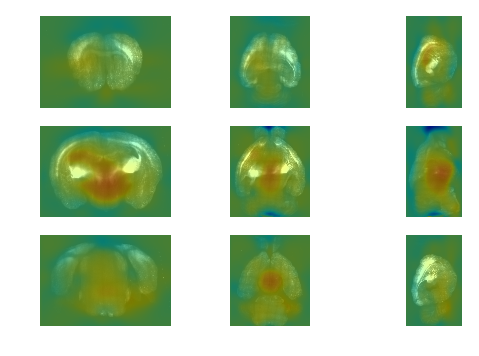

In [43]:
imgShow(inImg_lddmm, vmax=500, newFig=False)
imgShow(logJDet, newFig=False, alpha=0.5, cmap=plt.cm.jet, vmin=-2, vmax=2)
plt.show()

Let's add a colorbar so that it's clear what the color's mean. This is a little tricky so we'll do this one step at a time. First we get the current figure.

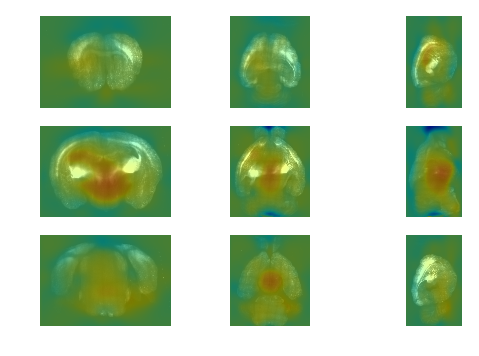

In [44]:
imgShow(inImg_lddmm, vmax=500, newFig=False)
imgShow(logJDet, newFig=False, alpha=0.5, cmap=plt.cm.jet, vmin=-2, vmax=2)
fig = plt.gcf()

There a 9 subplots in the figure.

In [45]:
fig.axes

Let's get the axis of the 0th subplot from the figure.

In [46]:
ax = fig.axes[0]

Each subplot has two images two images.  The 0th one is a slice from inImg_lddmm.  The 1st one is a slice from the logJDet.  Since we want the colorbar from logJDet we get the 1st image.

In [47]:
img_ax = ax.get_images()[1]

Now we make room for the colorbar, add an axis for it and the add it to the figure.

In [48]:
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.2, 0.05, 0.6])
cbar = fig.colorbar(img_ax, cax=cbar_ax) 

Putting it all together.

/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


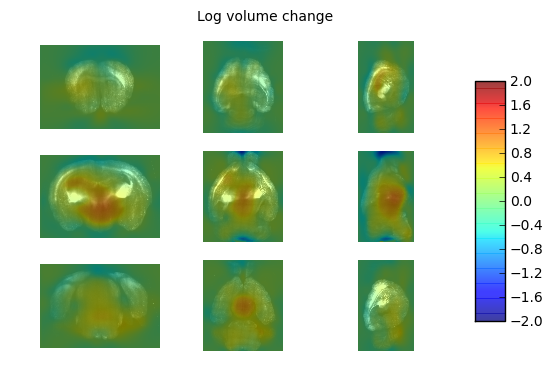

In [49]:
imgShow(inImg_lddmm, vmax=500, newFig=False)
imgShow(logJDet, newFig=False, alpha=0.5, cmap=plt.cm.jet, vmin=-2, vmax=2)
fig = plt.gcf()
ax = fig.axes[0]
img_ax = ax.get_images()[1]
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.2, 0.05, 0.6])
cbar = fig.colorbar(img_ax, cax=cbar_ax) 
plt.suptitle("Log volume change")
plt.show()

Since we see more reds, oranges and yellows than blues it's obvious that the CLARITY brain expaned in most places during registration.  We can also plot a histogram of the Jacobian values.

/cis/home/kwame/.local/lib/python2.7/site-packages/numpy/lib/function_base.py:583: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/cis/home/kwame/.local/lib/python2.7/site-packages/numpy/lib/function_base.py:584: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


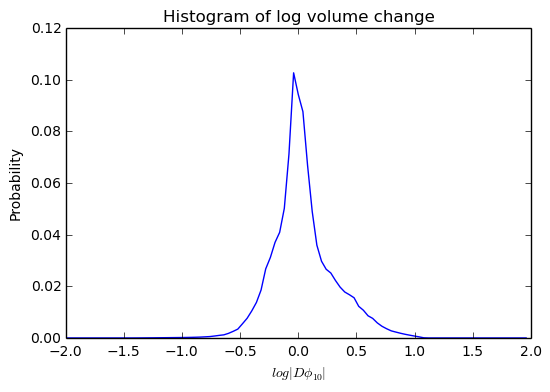

In [50]:
(values, bins) = np.histogram(sitk.GetArrayFromImage(logJDet), bins=100, range=(-2,2))
numVoxels = float(np.prod(logJDet.GetSize()))
plt.plot(bins[:-1], values / numVoxels)
plt.xlabel("$log |D \phi_{10} |$")
plt.ylabel("Probability")
plt.title("Histogram of log volume change")

### Measuring Distance
Simmilary we can plot the magnitude of the displacement

In [51]:
magField = sitk.VectorMagnitude(field)

Like before, since the field was computed on a downsampled grid, we upsample the field magnitude to the size of the deformed input image.

In [52]:
magField = imgResample(magField, spacing=inImg_lddmm.GetSpacing(), size=inImg_lddmm.GetSize())

Now we can overlay the dispacement magnitude on the deformed image

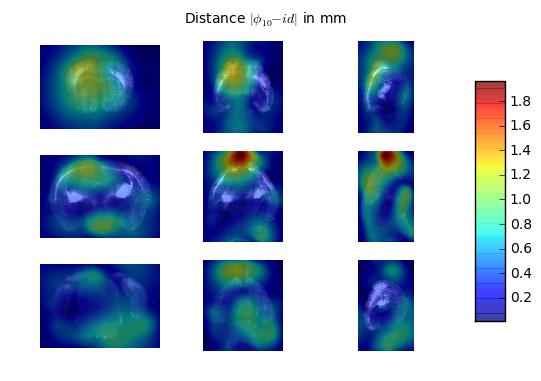

In [53]:
imgShow(inImg_lddmm, vmax=500, newFig=False)
imgShow(magField, newFig=False, alpha=0.5, cmap=plt.cm.jet)
fig = plt.gcf()
ax = fig.axes[0]
img_ax = ax.get_images()[1]
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.2, 0.05, 0.6])
cbar = fig.colorbar(img_ax, cax=cbar_ax) 
plt.suptitle("Distance $|\phi_{10} - id|$ in mm")
plt.show()

Clearly most displacement occured in the olfactory bulbs.  Likewise lets display a histogram of the distances.

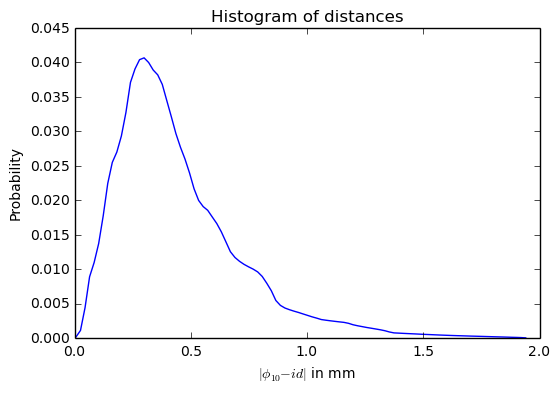

In [54]:
(values, bins) = np.histogram(sitk.GetArrayFromImage(magField), bins=100)
numVoxels = float(np.prod(magField.GetSize()))
plt.plot(bins[:-1], values/numVoxels)
plt.xlabel("$|\phi_{10} - id|$ in mm")
plt.ylabel("Probability")
plt.title("Histogram of distances")

## Uploading Results
### Uploading deformed ARA annotations
Recall that we made a copy of the downloaded CLARITY image

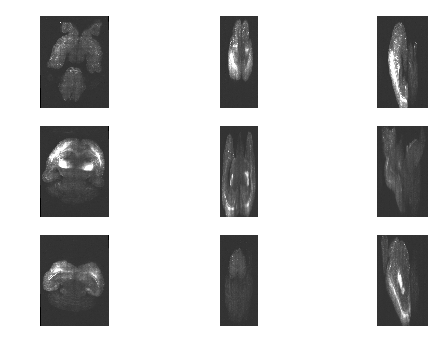

In [55]:
imgShow(inImg_download, vmax=500)

Recall that we also have ARA annotations

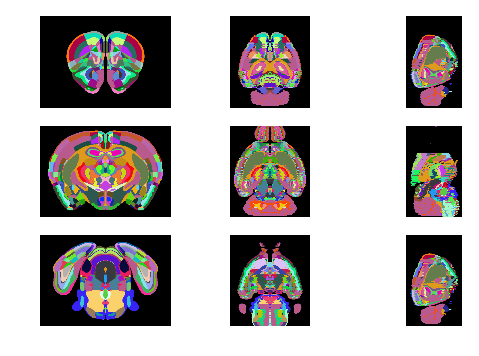

In [56]:
imgShow(refAnnoImg, vmax=1000, cmap=randCmap)

Before we can overlay the ARA annotations on the downloaded image we must transfom them to its space. Fortunatly this can be done since all spatial transforms in this tutorial are invertable.  First we construct an inverse displacement field which transforms the annotations from the ARA space to the space before registration.

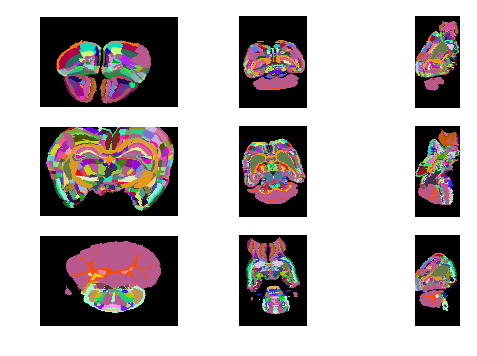

In [57]:
invAffine = affineInverse(affine)
invAffineField = affineToField(invAffine, refImg.GetSize(), refImg.GetSpacing())
invField = fieldApplyField(invAffineField, invField)
inAnnoImg = imgApplyField(refAnnoImg, invField,useNearest=True, size=inImg_reorient.GetSize())
imgShow(inAnnoImg, vmax=1000, cmap=randCmap)

Were not done yet.  We still need to reorient these annotations from **RSA** to **LAI** 

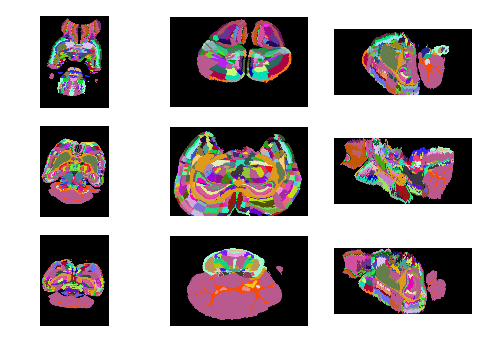

In [58]:
inAnnoImg = imgReorient(inAnnoImg, "RSA", "LAI")
imgShow(inAnnoImg, vmax=1000, cmap=randCmap)

Finally we resample the annotations to the spacing and size of the downloaded CLARITY image.  Lets look at the overlay.

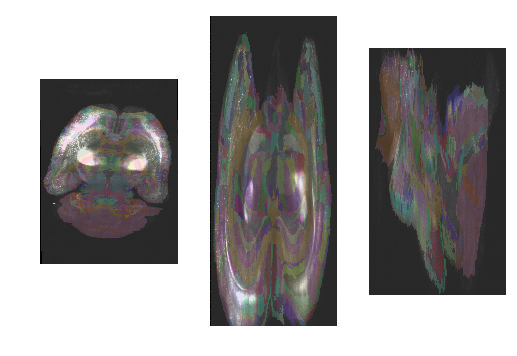

In [59]:
inAnnoImg = imgResample(inAnnoImg, spacing=inImg_download.GetSpacing(), size=inImg_download.GetSize(), useNearest=True)
imgShow(inImg_download, vmax=500, numSlices=1, newFig=False)
imgShow(inAnnoImg, vmax=1000, cmap=randCmap, alpha=0.2, numSlices=1, newFig=False)

We can upload these annotations at the lowest possible resolution.

In [ ]:
channel = "myAnnotationChannel"
imgUpload(inImg_lddmm, inToken, channel, resolution=5)

### Uploading deformed CLARITY image
We can also upload the ARA-aligned CLARITY brain back into ndstore.

In [ ]:
token = "myToken"
channel = "myChannel"
imgUpload(inImg_lddmm, token, channel)